In [1]:
import json
from preprocessor.preprocessor_pytorch import Preprocessor
from model.model_pytorch import Model
from postprocessor.postprocessor import Postprocesser
from evaluator.evaluator_pytorch import Evaluator
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm

def set_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)
    torch.manual_seed(seed_value)
set_seed(42)

# with open('parameters.json', 'r') as file:
#     params = json.load(file)

In [2]:
params = {
    "start_date": "2001-01-01",
    "stop_date": "2021-01-01",
    "stock_symbol": "^GSPC",
    "features_params": [
        {"type": "Trend", "method": "LocalExtrema", "oder_days": 2,
         "ma_days": 10, "trend_days": 5},
        {"type": "MACD", "fastperiod": 5, "slowperiod": 10, "signalperiod": 9},
        {"type": "ROC", "trend_days": 5},
        {"type": "Stochastic Oscillator", "trend_days": 5},
        {"type": "CCI", "timeperiod": 14},
        {"type": "RSI", "timeperiod": 14},
        {"type": "VMA", "timeperiod": 20},
        {"type": "PctChange"},
        {"type": "3M Treasury Yield", "start_date": "2001-01-01",
            "end_date": "2021-01-01"},
        {"type": "5Y Treasury Yield", "start_date": "2001-01-01",
            "end_date": "2021-01-01"},
        {"type": "10Y Treasury Yield",
            "start_date": "2001-01-01", "end_date": "2021-01-01"},
        {"type": "30Y Treasury Yield",
            "start_date": "2001-01-01", "end_date": "2021-01-01"}
    ],
    "data_cleaning": {
        "clean_type": "MissingData", 
        "strategy": "auto"
    },
    "split_ratio": 0.7,
    "target_col": "Trend",
    "feature_cols": [
        "MACD", "ROC", "CCI", "RSI", "VMA",
        "3M Treasury Yield", "5Y Treasury Yield",
        "10Y Treasury Yield", "30Y Treasury Yield"
    ],
    "look_back": 32,
    "predict_steps": 10,
    "train_slide_steps": 10,
    "test_slide_steps": 10,
    "model_params": {
        "LeNet": {
            "look_back": 32,
            "predict_steps": 10,
            "conv_1_in_channels": 19,
            "conv_1_out_channels": 8,
            "conv_1_kernel": 3,
            "conv_1_padding": 1,
            "MaxPool2d_1_kernel_size": 2,
            "fc_1_out_features": 512,
            "reshape": "False"
        },
        "LeNet_2": {
            "look_back": 32,
            "predict_steps": 10,
            "conv_1_in_channels": 19,
            "conv_1_out_channels": 6,
            "conv_1_kernel": 3,
            "conv_1_padding": 1,
            "MaxPool2d_1_kernel_size": 2,
            "conv_2_out_channels": 8,
            "conv_2_kernel": 3,
            "conv_2_padding": 1,
            "MaxPool2d_2_kernel_size": 2,
            "fc_1_out_features": 512,
            "reshape": "False"
        },
        "RNN": {
            "look_back": 32,
            "predict_steps": 10,
            "hidden_size": 32,
            "num_layers": 1,
            "dropout": 0.2,
            "reshape": "False"
        },
        "LSTM": {
            "look_back": 32,
            "predict_steps": 10,
            "hidden_size": 32,
            "num_layers": 1,
            "dropout": 0.2,
            "reshape": "False"
        },
        "CNN_LSTM": {
            "look_back": 32,
            "predict_steps": 10,
            "conv_1_in_channels": 19,
            "conv_1_out_channels": 6,
            "conv_1_kernel": 3,
            "conv_1_padding": 1,
            "MaxPool2d_1_kernel_size": 2,
            "conv_2_out_channels": 8,
            "conv_2_kernel": 3,
            "conv_2_padding": 1,
            "MaxPool2d_2_kernel_size": 2,
            "fc_1_out_features": 512,
            "hidden_size": 32,
            "num_layers": 1,
            "dropout": 0.2,
            "reshape": "False"
        },
        "DNN": {   
            "predict_steps": 10
        }
    },
    "model_type" : "LeNet",
    "training_epoch_num": 1000,
    "online_training_epoch_num": 10,
    "learning_rate": 0.001,
    "filter": 10,
    "patience": 10,
    "min_delta": 0.001,
  }
  

In [3]:
preprocessor = Preprocessor()
data = preprocessor.fetch_stock_data(params['stock_symbol'], params['start_date'], params['stop_date'])
for single_feature_params in params['features_params']:
    feature_type = single_feature_params["type"]
    data = preprocessor.add_feature(data, feature_type, **single_feature_params)
data, issues_detected = preprocessor.add_data_cleaner(data,
    clean_type=params['data_cleaning']['clean_type'], strategy=params['data_cleaning']['strategy'])
X_train_SP, y_train_SP, X_test, y_test, train_dates, test_dates = \
    preprocessor.process_data(data, split_ratio=params['split_ratio'], target_col=params['target_col'],
                            feature_cols=None, look_back=params['look_back'],
                            predict_steps=params['predict_steps'],
                            train_slide_steps=params['train_slide_steps'],
                            test_slide_steps=params['test_slide_steps'],
                            reshape=params['model_params'][params['model_type']]['reshape'])
X_newest, x_newest_date = preprocessor.create_x_newest_data(data, params['look_back'])


[*********************100%***********************]  1 of 1 completed


c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0203\project\preprocessor\preprocessor_pytorch.py:91: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0203\project\preprocessor\preprocessor_pytorch.py:88: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 1
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0203\project\preprocessor\preprocessor_pytorch.py:95: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
c:\Users\e4903\Desktop\code\2023_hw\reverse_pr

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
preprocessor = Preprocessor()
data = preprocessor.fetch_stock_data('^IXIC', params['start_date'], params['stop_date'])
for single_feature_params in params['features_params']:
    feature_type = single_feature_params["type"]
    data = preprocessor.add_feature(data, feature_type, **single_feature_params)
data, issues_detected = preprocessor.add_data_cleaner(data, 
    clean_type=params['data_cleaning']['clean_type'], strategy=params['data_cleaning']['strategy'])
X_train_NAS, y_train_NAS, _, _, train_dates_NAS, _ = \
    preprocessor.process_data(data, split_ratio=params['split_ratio'], target_col=params['target_col'], 
                            feature_cols=None, look_back=params['look_back'],
                            predict_steps=params['predict_steps'], 
                            train_slide_steps=params['train_slide_steps'], 
                            test_slide_steps=params['test_slide_steps'],
                            reshape=params['model_params'][params['model_type']]['reshape'])
X_newest, x_newest_date = preprocessor.create_x_newest_data(data, params['look_back'])


[*********************100%***********************]  1 of 1 completed


c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0203\project\preprocessor\preprocessor_pytorch.py:91: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0203\project\preprocessor\preprocessor_pytorch.py:88: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 1
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0203\project\preprocessor\preprocessor_pytorch.py:98: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 1
c:\Users\e4903\Desktop\code\2023_hw\reverse_pr

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
preprocessor = Preprocessor()
data = preprocessor.fetch_stock_data('^DJI', params['start_date'], params['stop_date'])
for single_feature_params in params['features_params']:
    feature_type = single_feature_params["type"]
    data = preprocessor.add_feature(data, feature_type, **single_feature_params)
data, issues_detected = preprocessor.add_data_cleaner(data, 
    clean_type=params['data_cleaning']['clean_type'], strategy=params['data_cleaning']['strategy'])
X_train_DJI, y_train_DJI, _, _, train_dates_DJI, _ = \
    preprocessor.process_data(data, split_ratio=params['split_ratio'], target_col=params['target_col'], 
                            feature_cols=None, look_back=params['look_back'],
                            predict_steps=params['predict_steps'], 
                            train_slide_steps=params['train_slide_steps'], 
                            test_slide_steps=params['test_slide_steps'],
                            reshape=params['model_params'][params['model_type']]['reshape'])
X_newest, x_newest_date = preprocessor.create_x_newest_data(data, params['look_back'])


[*********************100%***********************]  1 of 1 completed


c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0203\project\preprocessor\preprocessor_pytorch.py:91: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0203\project\preprocessor\preprocessor_pytorch.py:88: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 1
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0203\project\preprocessor\preprocessor_pytorch.py:98: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 1
c:\Users\e4903\Desktop\code\2023_hw\reverse_pr

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
preprocessor = Preprocessor()
data = preprocessor.fetch_stock_data('^RUT', params['start_date'], params['stop_date'])
for single_feature_params in params['features_params']:
    feature_type = single_feature_params["type"]
    data = preprocessor.add_feature(data, feature_type, **single_feature_params)
data, issues_detected = preprocessor.add_data_cleaner(data, 
    clean_type=params['data_cleaning']['clean_type'], strategy=params['data_cleaning']['strategy'])
X_train_RUT, y_train_RUT, _, _, train_dates_RUT, _ = \
    preprocessor.process_data(data, split_ratio=params['split_ratio'], target_col=params['target_col'], 
                            feature_cols=None, look_back=params['look_back'],
                            predict_steps=params['predict_steps'], 
                            train_slide_steps=params['train_slide_steps'], 
                            test_slide_steps=params['test_slide_steps'],
                            reshape=params['model_params'][params['model_type']]['reshape'])
X_newest, x_newest_date = preprocessor.create_x_newest_data(data, params['look_back'])


[*********************100%***********************]  1 of 1 completed

c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0203\project\preprocessor\preprocessor_pytorch.py:91: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0203\project\preprocessor\preprocessor_pytorch.py:88: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 1
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0203\project\preprocessor\preprocessor_pytorch.py:95: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
c:\Users\e4903\Desktop\code\2023_hw\reverse_pr

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train_datasets = [X_train_SP, X_train_NAS, X_train_DJI, X_train_RUT]
y_train_datasets = [y_train_SP, y_train_NAS, y_train_DJI, y_train_RUT]
num_samples = min(len(X_train_SP), len(X_train_NAS), len(X_train_DJI), len(X_train_RUT))
# X_train_datasets = [X_train_SP]
# y_train_datasets = [y_train_SP]
# num_samples = len(X_train_SP)
data_len = len(X_train_datasets[0])

X_train_combined = []
y_train_combined = []
for i in tqdm.tqdm(range(num_samples)):
    for dataset in X_train_datasets:
        X_train_combined.append(dataset[i])
        y_train_combined.append(y_train_datasets[0][i])

X_train = torch.stack(X_train_combined, dim=0)
y_train = torch.stack(y_train_combined, dim=0)

# Randomly shuffle X_train and y_train in the same order
indices = np.arange(len(X_train))
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
# X_train = X_train[indices]
# y_train = y_train[indices]

# print(X_train.shape)


100%|██████████| 347/347 [00:00<00:00, 17205.62it/s]

Training set shape: torch.Size([1110, 32, 19])
Validation set shape: torch.Size([278, 32, 19])


In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([1110, 32, 19]),
 torch.Size([1110, 10, 2]),
 torch.Size([147, 32, 19]),
 torch.Size([147, 10, 2]))

In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
import talib
from abc import ABC, abstractmethod
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import from_numpy
import torch

class FeatureBase(ABC):
    """
    Abstract base class for all features.
    """
    @abstractmethod
    def compute(self, data=None, *args, **kwargs):
        """
        Abstract method to compute the feature value for the given data.
        """
        pass


class IndicatorTrend(FeatureBase):
    """
    Indicator to calculate the trend based on various methods.
    """

    def compute(self, data, *args, **kwargs):
        """
        Compute the trend for the given data using the specified method.
        """
        method = kwargs.get('method', 'MA')
        ma_days = kwargs.get('ma_days', 20)
        oder_days = kwargs.get('oder_days', 20)
        trend_days = kwargs.get('trend_days', 5)

        if method == 'MA':
            return self.calculate_trend_MA(data, ma_days=ma_days, trend_days=trend_days)
        elif method == 'LocalExtrema':
            return self.calculate_trend_LocalExtrema(data, oder_days=oder_days)
        else:
            raise ValueError(f"Invalid trend calculation method: {method}")

    def calculate_trend_MA(self, data, ma_days=20, trend_days=5):
        """
        Calculate trend using Moving Average method.
        """
        data['MA'] = data['Close'].rolling(window=ma_days).mean()
        data['Trend'] = np.nan
        n = len(data)

        for i in range(n - trend_days + 1):
            if all(data['MA'].iloc[i + j] < data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
                data['Trend'].iloc[i:i + trend_days] = 0 # up trend
            elif all(data['MA'].iloc[i + j] > data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
                data['Trend'].iloc[i:i + trend_days] = 1 # down trend
        data['Trend'].fillna(method='ffill', inplace=True)
        return data.drop(columns=['MA'])

    def calculate_trend_LocalExtrema(self, data, oder_days=20):
        """
        Calculate trend using Local Extrema method.
        """
        local_max_indices = argrelextrema(
            data['Close'].values, np.greater_equal, order=oder_days)[0]
        local_min_indices = argrelextrema(
            data['Close'].values, np.less_equal, order=oder_days)[0]
        data['Local Max'] = data.iloc[local_max_indices]['Close']
        data['Local Min'] = data.iloc[local_min_indices]['Close']
        data['Trend'] = np.nan
        prev_idx = None
        prev_trend = None
        prev_type = None

        for idx in sorted(np.concatenate([local_max_indices, local_min_indices])):
            if idx in local_max_indices:
                current_type = "max"
            else:
                current_type = "min"

            if prev_trend is None:
                if current_type == "max":
                    prev_trend = 1
                else:
                    prev_trend = 0
            else:
                if prev_type == "max" and current_type == "min":
                    data.loc[prev_idx:idx, 'Trend'] = 1
                    prev_trend = 1 # down trend
                elif prev_type == "min" and current_type == "max":
                    data.loc[prev_idx:idx, 'Trend'] = 0
                    prev_trend = 0 # up trend
                else:
                    if current_type == "max":
                        data.loc[prev_idx:idx, 'Trend'] = 0
                        prev_trend = 0 # up trend
                    else:
                        data.loc[prev_idx:idx, 'Trend'] = 1
                        prev_trend = 1 # down trend

            prev_idx = idx
            prev_type = current_type
        data['Trend'].fillna(method='ffill', inplace=True)
        return data.drop(columns=['Local Max', 'Local Min'])


class IndicatorMACD(FeatureBase):
    """
    Indicator to calculate the Moving Average Convergence Divergence (MACD).
    """

    def compute(self, data, *args, **kwargs):
        fastperiod = kwargs.get('fastperiod', 5)
        slowperiod = kwargs.get('slowperiod', 10)
        signalperiod = kwargs.get('signalperiod', 9)
        data['MACD'], _, _ = talib.MACD(
            data['Close'], fastperiod=fastperiod, slowperiod=slowperiod, signalperiod=signalperiod)
        return data


class IndicatorROC(FeatureBase):
    def compute(self, data, *args, **kwargs):
        trend_days = kwargs.get('trend_days', 5)
        data['ROC'] = talib.ROC(data['Close'], timeperiod=trend_days)
        return data


class IndicatorStochasticOscillator(FeatureBase):
    def compute(self, data, *args, **kwargs):
        trend_days = kwargs.get('trend_days', 5)
        data['StoK'], data['StoD'] = talib.STOCH(
            data['High'], data['Low'], data['Close'], fastk_period=trend_days, slowk_period=3, slowd_period=3)
        return data


class IndicatorCCI(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['CCI'] = talib.CCI(data['High'], data['Low'],
                                data['Close'], timeperiod=timeperiod)
        return data


class IndicatorRSI(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['RSI'] = talib.RSI(data['Close'], timeperiod=timeperiod)
        return data


class IndicatorVMA(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 20)
        data['VMA'] = talib.MA(data['Volume'], timeperiod=timeperiod)
        return data


class IndicatorPctChange(FeatureBase):
    def compute(self, data, *args, **kwargs):
        data['pctChange'] = data['Close'].pct_change() * 100
        return data


class TreasuryYieldThreeMonth(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        three_month_treasury_yield = yf.download(
            "^IRX", start_date, end_date)["Close"]
        data['3M Treasury Yield'] = three_month_treasury_yield
        return data


class TreasuryYieldFiveYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        five_year_treasury_yield = yf.download(
            "^FVX", start_date, end_date)["Close"]
        data['5Y Treasury Yield'] = five_year_treasury_yield
        return data


class TreasuryYieldTenYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        ten_year_treasury_yield = yf.download(
            "^TNX", start_date, end_date)["Close"]
        data['10Y Treasury Yield'] = ten_year_treasury_yield
        return data


class TreasuryYieldThirtyYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        thirty_year_treasury_yield = yf.download(
            "^TYX", start_date, end_date)["Close"]
        data['30Y Treasury Yield'] = thirty_year_treasury_yield
        return data
# Add other features here as needed


class FeatureFactory:
    """
    Factory class dedicated to creating various technical features.
    """
    @staticmethod
    def get_feature(feature_type):
        """
        Retrieve the desired feature based on the specified type.
        """
        features = {
            "Trend": IndicatorTrend,
            "MACD": IndicatorMACD,
            "ROC": IndicatorROC,
            "Stochastic Oscillator": IndicatorStochasticOscillator,
            "CCI": IndicatorCCI,
            "RSI": IndicatorRSI,
            "VMA": IndicatorVMA,
            "PctChange": IndicatorPctChange,
            "3M Treasury Yield": TreasuryYieldThreeMonth,
            "5Y Treasury Yield": TreasuryYieldFiveYear,
            "10Y Treasury Yield": TreasuryYieldTenYear,
            "30Y Treasury Yield": TreasuryYieldThirtyYear,
            # Add other features here as needed
        }
        feature = features.get(feature_type)
        if feature is None:
            raise ValueError(f"Invalid feature type: {feature_type}")
        return feature()


class CleanerBase(ABC):
    """Abstract base class for data processors."""
    @abstractmethod
    def check(self, data):
        """Method to check the data for issues."""
        pass

    @abstractmethod
    def clean(self, data):
        """Method to clean the data from identified issues."""
        pass


class CleanerMissingValue(CleanerBase):
    """Concrete class for checking and handling missing data."""

    def check(self, data):
        """Check for missing data in the dataframe."""
        return data.isnull().sum()

    def clean(self, data, strategy='auto'):
        """Handle missing data based on the chosen strategy."""
        if strategy == 'auto':
            while data.iloc[0].isnull().any():
                data = data.iloc[1:]
            data.fillna(method='ffill', inplace=True)

        elif strategy == 'drop':
            data.dropna(inplace=True)

        elif strategy == 'fillna':
            data.fillna(method='ffill', inplace=True)

        elif strategy == 'none':
            pass

        else:
            raise ValueError("Invalid strategy provided.")

        return data


class ProcessorFactory:
    """Factory class to creat data processors."""
    @staticmethod
    def get_cleaner(clean_type, *args, **kwargs):
        """creat a data processor based on the provided type."""
        if clean_type == "MissingData":
            return CleanerMissingValue(*args, **kwargs)
        else:
            raise ValueError(f"Processor type {clean_type} not recognized.")

    @staticmethod
    def get_standardize_method(data, method='MinMaxScaler'):
        """Standardize the data using the specified method."""
        if method == 'StandardScaler':
            scaler = StandardScaler()
        elif method == 'MinMaxScaler':
            scaler = MinMaxScaler()
        else:
            raise ValueError(f"Invalid scaler method: {method}.")
        return scaler.fit_transform(data)

    @staticmethod
    def standardize_and_split_data(data, split_ratio=0.7, 
                                   target_col="Trend", feature_cols=None):
        """Standardize the data and split it into training and testing sets."""
        if not feature_cols:
            feature_cols = data.columns.to_list()
        # x_data 設為target_col以外的其他欄位
        # x_data = data.drop(columns=[target_col])
        x_data = data[feature_cols]
        y_data = pd.get_dummies(data[target_col], prefix='Trend')
        split_idx = int(len(x_data) * split_ratio)
        if split_idx < 1 or split_idx >= len(x_data):
            raise ValueError(
                "Invalid split ratio leading to incorrect data partitioning.")

        X_test = x_data.iloc[split_idx:]
        y_test = y_data.iloc[split_idx:]
        X_train = x_data.iloc[:split_idx]
        y_train = y_data.iloc[:split_idx]

        return X_train, y_train, X_test, y_test

    @staticmethod
    def prepare_multistep_data(x_data, y_data, look_back, predict_steps, slide_steps=1):
        """
        Prepare the data for multi-step prediction 
        and apply standardization within each sliding window.
        """
        x_date = []
        y_date = []
        x_data_multistep = []
        y_data_multistep = []

        for i in range(0, len(x_data) - look_back - predict_steps + 1, slide_steps):
            x_date.append(x_data.index[i:i + look_back])
            y_date.append(
                x_data.index[i + look_back:i + look_back + predict_steps])
            x_window = x_data.iloc[i:i + look_back].values
            y_window = y_data.iloc[i + look_back:i +
                                   look_back + predict_steps].values
            x_window_standardized = ProcessorFactory.get_standardize_method(
                x_window)
            x_data_multistep.append(x_window_standardized)
            y_data_multistep.append(y_window)

        return np.array(x_data_multistep), np.array(y_data_multistep), \
            np.array(x_date), np.array(y_date)

    @staticmethod
    def preprocess_for_prediction(x_data, look_back, slide_steps=1):
        """
        Prepare multiple instances of x_data for multi-step prediction.
        """
        x_date = []
        x_data_multistep = []

        for i in range(0, len(x_data) - look_back + 1, slide_steps):
            x_date.append(x_data.index[i:i + look_back])
            x_window = x_data.iloc[i:i + look_back].values
            x_window_standardized = ProcessorFactory.get_standardize_method(
                x_window)
            x_data_multistep.append(x_window_standardized)

        return np.array(x_data_multistep), np.array(x_date)


class Preprocessor:
    """
    Fetching, processing, and preparing model data.
    """

    def __init__(self, start_date=None, end_date=None):
        self.start_date = start_date
        self.end_date = end_date
        self.features = []
        self.processors = []

    def fetch_stock_data(self, stock_symbol, start_date=None, end_date=None):
        """Fetch stock data from Yahoo Finance."""
        if start_date:
            self.start_date = start_date
        if end_date:
            self.end_date = end_date
        return yf.download(stock_symbol, start=self.start_date, end=self.end_date)

    def add_feature(self, data, feature_type, *args, **kwargs):
        feature = FeatureFactory.get_feature(feature_type)
        return feature.compute(data, *args, **kwargs)

    def add_data_cleaner(self, data, clean_type='MissingData', strategy='auto'):
        """Method to check and clean the data using a specific processor."""
        processor = ProcessorFactory.get_cleaner(clean_type)
        issues = processor.check(data)
        data = processor.clean(data, strategy=strategy)
        return data, issues
    
    def reshape_data(self, data):
        return data.reshape(data.shape[0], data.shape[2], data.shape[1])
    
    def process_data(self, data, split_ratio=0.7, target_col="Trend",
                      feature_cols=None, look_back=64, predict_steps=16, 
                      train_slide_steps=1, test_slide_steps=16, reshape="False"):
        """
        Use ProcessorFactory to standardize and split the data, 
        and prepare it for multi-step prediction if required.
        """
        X_train, y_train, X_test, y_test = ProcessorFactory.standardize_and_split_data(
            data, split_ratio, target_col, feature_cols)

        if look_back and predict_steps:
            X_train, y_train, train_dates, _ = ProcessorFactory.prepare_multistep_data(
                X_train, y_train, look_back, predict_steps, train_slide_steps)
            X_test, y_test, _, test_dates = ProcessorFactory.prepare_multistep_data(
                X_test, y_test, look_back, predict_steps, test_slide_steps)
            if reshape == "True":
                X_train = self.reshape_data(X_train)
                X_test = self.reshape_data(X_test)
                y_train = self.reshape_data(y_train)
                y_test = self.reshape_data(y_test)
            X_train = from_numpy(X_train).float()
            y_train = from_numpy(y_train).float()
            X_test = from_numpy(X_test).float()
            y_test = from_numpy(y_test).float()
            return X_train, y_train, X_test, y_test, train_dates, test_dates
        else:
            raise ValueError(
                "Invalid look_back or predict_steps provided for data preparation.")

    def create_x_newest_data(self, data, data_length, look_back=None, reshape=False):
        """
        Create the newest X data for prediction using a specified number of the latest records.
        """
        if not look_back:
            look_back = data_length

        if data_length > len(data):
            raise ValueError(
                "data_length exceeds the total number of available records.")

        newest_data = data.tail(data_length)
        X_newest, x_date = ProcessorFactory.preprocess_for_prediction(
            newest_data, look_back)
        if reshape == "True":
            X_newest = self.reshape_data(X_newest)
        X_newest = from_numpy(X_newest).float()

        return X_newest, x_date
    
    def change_values_after_first_reverse_point(self, y:torch.Tensor):
        modified_y = torch.zeros_like(y)
        for idx, sub_y in enumerate(y):
            array = sub_y.numpy()
            transition_found = False
            for i in range(1, len(array)):
                if not (array[i] == array[i-1]).all():
                    array[i:] = array[i]
                    transition_found = True
                    break
            if not transition_found:
                array = sub_y.numpy()
            modified_y[idx] = torch.tensor(array)

        return modified_y


In [10]:
def apply_weights(y_train: torch.tensor, weight_before=1, weight_after=2):
    weights = torch.zeros_like(y_train)
    for idx, sub_y_train in enumerate(y_train):
        array = sub_y_train.numpy()
        sub_weights = [weight_before] * len(array)
        for i in range(1, len(array)):
            if not (array[i] == array[i-1]).all():
                sub_weights[i:] = [weight_after] * (len(array) - i)
                break
        for j in range(len(sub_weights)):
            weights[idx, j] = torch.tensor([sub_weights[j]] * y_train.shape[2])
    return weights

# 計算權重
weights = apply_weights(y_train)
weights.shape


torch.Size([1110, 10, 2])

In [11]:
# X_train = torch.transpose(X_train, 1, 2)
# X_test = torch.transpose(X_test, 1, 2)
# X_newest = torch.transpose(X_newest, 1, 2)
# y_train = torch.transpose(y_train, 1, 2)
# y_test = torch.transpose(y_test, 1, 2)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([1110, 32, 19]),
 torch.Size([1110, 10, 2]),
 torch.Size([147, 32, 19]),
 torch.Size([147, 10, 2]))

In [13]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0.1):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def train(model, X_train, y_train, X_val, y_val, train_weights, val_weights):
    train_loss_function = nn.BCELoss(weight=train_weights)
    val_loss_function = nn.BCELoss(weight=val_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopper = EarlyStopper(patience=10, min_delta=0.0001)

    train_losses = []
    train_accuracy = []
    val_losses = []
    val_accuracy = []

    num_epochs = 1000
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        optimizer.zero_grad()

        # forward pass
        outputs = model(X_train)
        loss = train_loss_function(outputs, y_train)
        # backward pass and update weights
        loss.backward()
        optimizer.step()

        # calculate training accuracy
        _, predicted = torch.max(outputs.data, -1)
        correct = (predicted == y_train.argmax(dim=-1)).sum().item()
        accuracy = correct / (y_train.size(-3)*y_train.size(-2))
        train_losses.append(loss.item())
        train_accuracy.append(accuracy)

        # calculate validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = val_loss_function(val_outputs, y_val)
            _, val_predicted = torch.max(val_outputs.data, -1)
            val_correct = (val_predicted == y_val.argmax(dim=-1)).sum().item()
            accuracy = val_correct / (y_val.size(-3)*y_val.size(-2))
            val_losses.append(val_loss.item())
            val_accuracy.append(accuracy)

        # early stopping based on training loss
        if early_stopper.early_stop(val_loss.item()):             
            break

    history = {
        'loss': train_losses,
        'binary_accuracy': train_accuracy,
        'val_loss': val_losses,
        'val_binary_accuracy': val_accuracy
    }
    return history


def infer(model, X_test):
    y_pred = model(X_test)
    return y_pred

In [14]:
def online_train(model, X_train, y_train, single_X_test, 
                    single_y_test, data_update_mode='newest'):
    # TODO: online dataset should be processrd in Preprocessor
    if data_update_mode == 'append':
        online_X_train = torch.cat((X_train, single_X_test), dim=0)
        online_y_train = torch.cat((y_train, single_y_test), dim=0)
    elif data_update_mode == 'replace':
        online_X_train = torch.cat((X_train[1:], single_X_test), dim=0)
        online_y_train = torch.cat((y_train[1:], single_y_test), dim=0)
    elif data_update_mode == 'newest':
        online_X_train = single_X_test
        online_y_train = single_y_test
    else:
        raise ValueError(f"Invalid data update mode: {data_update_mode}")

    # Add the instance and its actual result to the training dataset
    X_train = np.append(X_train, single_X_test, axis=0)
    y_train = np.append(y_train, single_y_test, axis=0)
    
    y_train = torch.tensor(y_train, dtype=torch.float32)
    
    online_train_weights = apply_weights(y_train)
    loss_function = nn.BCELoss(weight=online_train_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 10
    history = {}
    for epoch in range(num_epochs):
        # Retrain the model on this updated dataset
        model.train()
        optimizer.zero_grad()

        # forward pass
        outputs = model(online_X_train)
        loss = loss_function(outputs, online_y_train)
        _, predicted = torch.max(outputs.data, -1)
        correct = (predicted == online_y_train.argmax(dim=-1)).sum().item()
        accuracy = correct / online_y_train.size(-2)
        # backward pass and update weights
        loss.backward()
        optimizer.step()
    history = {
        'loss': loss.item() / online_y_train.size(-2),
        'binary_accuracy': accuracy
        }
    return history

In [15]:
class ModelDNN(nn.Module):
    def __init__(self, params, input_shape):
        super(ModelDNN, self).__init__()

        # Calculate flattened input size
        input_size = input_shape[1] * input_shape[2]
        self.predict_step = params["model_params"]["DNN"]['predict_steps']
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_size, self.predict_step*32)
        self.fc2 = nn.Linear(self.predict_step*32, self.predict_step*16)
        self.fc3 = nn.Linear(self.predict_step*16, self.predict_step*8)
        self.fc4 = nn.Linear(self.predict_step*8, self.predict_step*4)
        self.fc5 = nn.Linear(self.predict_step*4, self.predict_step*2)

        # Layer normalization layers
        self.ln1 = nn.LayerNorm(self.predict_step*32)
        self.ln2 = nn.LayerNorm(self.predict_step*16)
        self.ln3 = nn.LayerNorm(self.predict_step*8)
        self.ln4 = nn.LayerNorm(self.predict_step*4)
        self.ln5 = nn.LayerNorm(self.predict_step*2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]

        # Fully connected layers with ReLU activations, layer normalization, and dropout
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.ln3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.ln4(self.fc4(x)))
        x = self.dropout(x)
        x = self.ln5(self.fc5(x))  # Last layer with LayerNorm but without ReLU

        # Apply sigmoid to the final layer
        x = torch.sigmoid(x)

        # Reshape the output to match target shape
        output = x.view(-1, self.predict_step, 2)  # Reshape to [batch_size, 2, 8]

        return output


In [16]:
def change_values_after_first_reverse_point(y:torch.Tensor):
    modified_y = torch.zeros_like(y)
    for idx, sub_tensor in enumerate(y):
        array = sub_tensor.numpy()
        transition_found = False
        for i in range(1, len(array)):
            if not (array[i] == array[i-1]).all():
                array[i:] = array[i]
                transition_found = True
                break
        if not transition_found:
            array = sub_tensor.numpy()
        modified_y[idx] = torch.tensor(array)

    return modified_y

In [17]:
y_train = change_values_after_first_reverse_point(y_train)
y_test = change_values_after_first_reverse_point(y_test)
train_weights = apply_weights(y_train)
val_weights = apply_weights(y_val)

In [18]:
y_train[0]

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [19]:
weights[0]

tensor([[1., 1.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.]])

In [20]:
y_train.shape, y_test.shape

(torch.Size([1110, 10, 2]), torch.Size([147, 10, 2]))

In [21]:
# Create a new model if no pre-trained model is provided
model = ModelDNN(params=params, input_shape=X_train.shape)
# Train the new model
history = train(model, X_train, y_train, X_val, y_val, train_weights, val_weights)


  0%|          | 3/1000 [00:00<02:52,  5.79it/s]

  1%|          | 10/1000 [00:02<04:00,  4.12it/s]


In [22]:
online_training_losses = []
online_training_acc = []
y_preds = []
for i in tqdm.tqdm(range(len(X_test))):
    # Predict the next instance
    y_pred = infer(model, X_test[i:i+1])
    y_preds.append(y_pred[0])

    # Perform online training
    online_history = online_train(
        model, X_train, y_train, X_test[i:i+1], y_test[i:i+1], data_update_mode='append')
    # for epoch in online_history:
    online_training_losses.append(online_history['loss'])
    online_training_acc.append(
        online_history['binary_accuracy'])
y_preds = torch.stack(y_preds).detach().numpy()

100%|██████████| 147/147 [07:57<00:00,  3.25s/it]


In [23]:
# model_wrapper = Model()
# model, history, y_preds, online_training_losses, online_training_acc = \
#     model_wrapper.run(params['model_type'], params['look_back'], params['model_params']['LeNet'],
#                         X_train, y_train, X_test, y_test)


In [24]:
y_test.shape, y_preds.shape

(torch.Size([147, 10, 2]), (147, 10, 2))

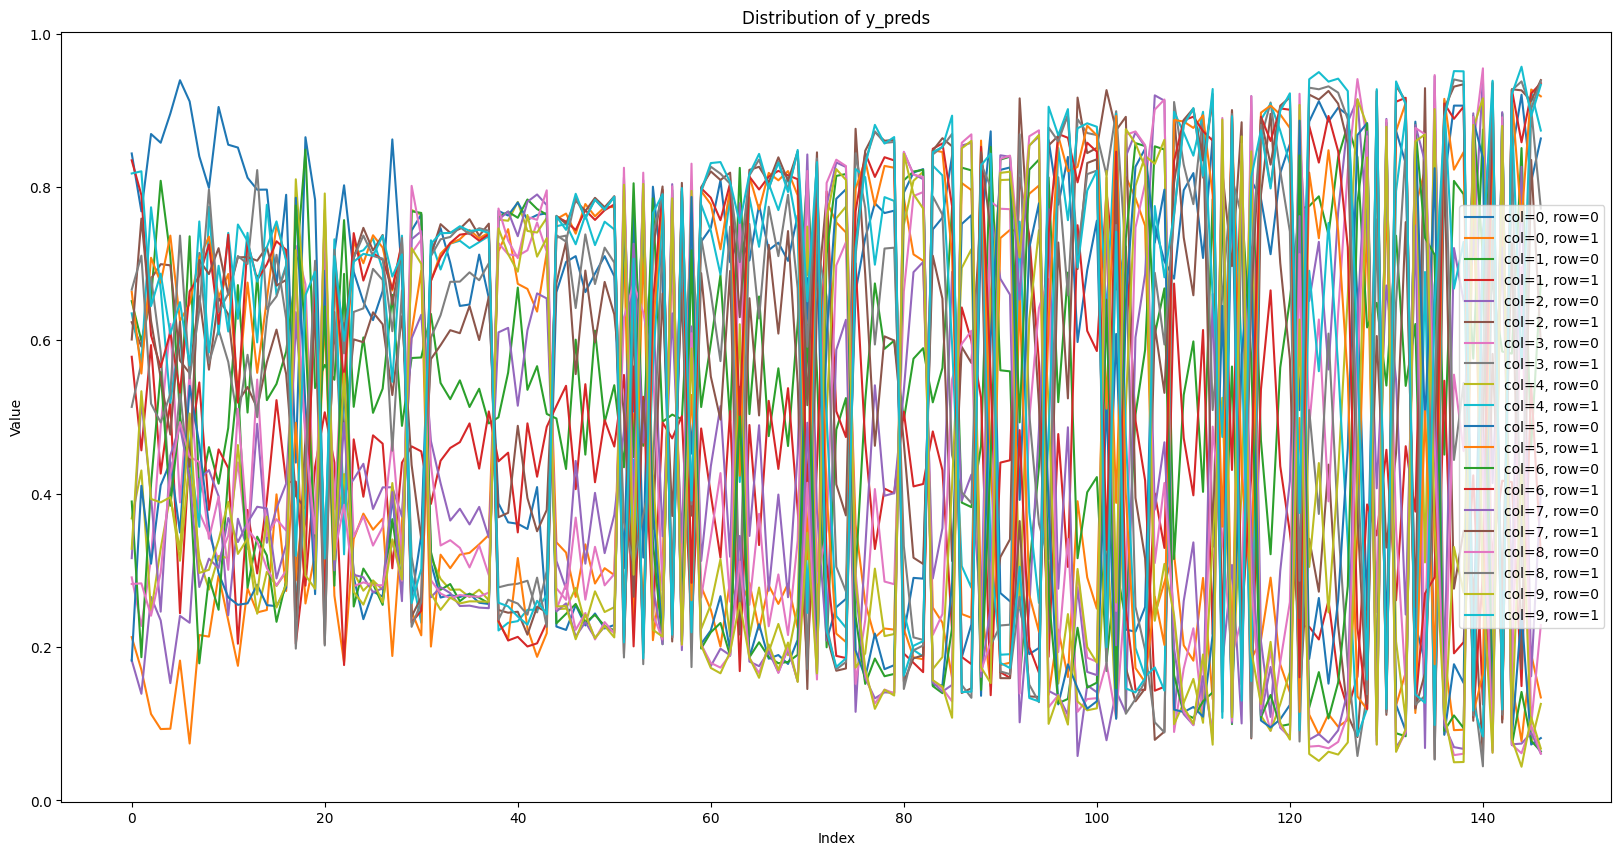

In [25]:
import matplotlib.pyplot as plt

# Plot the distribution of each column in y_preds
plt.figure(figsize=(20, 10))
for col in range(y_preds.shape[1]):
    for row in range(y_preds.shape[2]):
        plt.plot(y_preds[:, col, row], label=f'col={col}, row={row}')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Distribution of y_preds')
plt.legend()
plt.show()


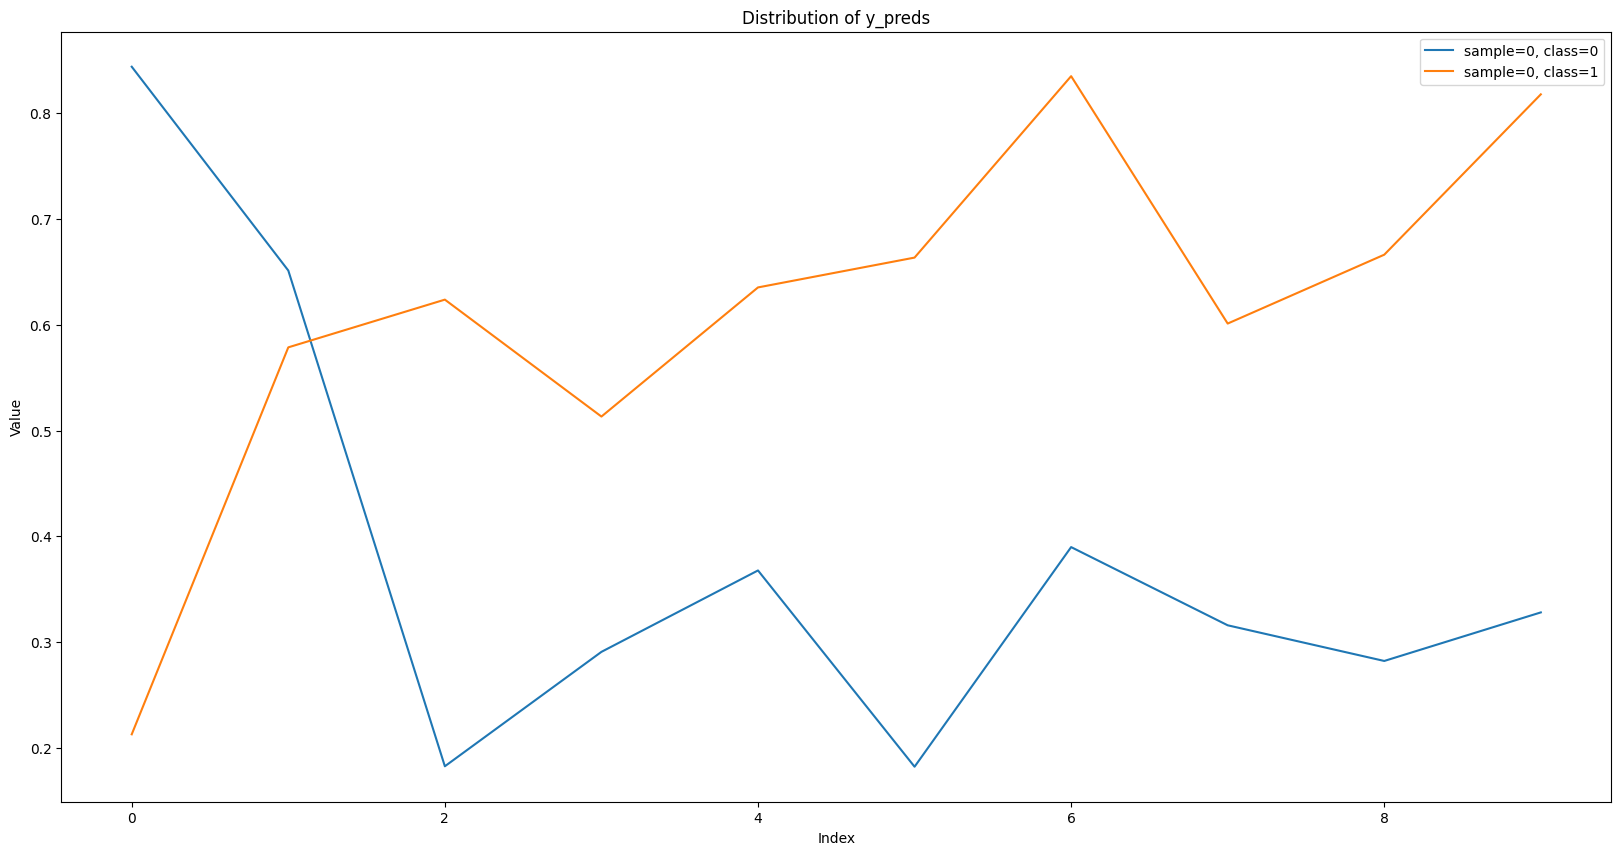

In [26]:
import matplotlib.pyplot as plt

# Plot the distribution of each column in y_preds
plt.figure(figsize=(20, 10))
# for col in range(y_preds.shape[0]):
#     for row in range(y_preds.shape[2]):
for col in range(1):
    for row in range(2):
        plt.plot(y_preds[col, :, row], label=f'sample={col}, class={row}')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Distribution of y_preds')
plt.legend()
plt.show()


In [27]:
import numpy as np
import pandas as pd

class Postprocesser:
    def __init__(self):
        pass
    
    def check_shape(self, X_train, X_test, X_newest, y_train, y_test, y_preds, reshape="False"):
        if reshape == "True":
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1])
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1])
            X_newest = X_newest.reshape(X_newest.shape[0], X_newest.shape[2], X_newest.shape[1])
            y_train = y_train.reshape(y_train.shape[0], y_train.shape[2], y_train.shape[1])
            y_test = y_test.reshape(y_test.shape[0], y_test.shape[2], y_test.shape[1])
            y_preds = y_preds.reshape(y_preds.shape[0], y_preds.shape[2], y_preds.shape[1])
        return X_train, X_test, X_newest, y_train, y_test, y_preds
    
    def modify_rows(self, arr):
        for row in arr:
            # Find the first index in the row where the change occurs
            change_index = np.where(np.diff(row) != 0)[0]
            if change_index.size > 0:
                first_change_index = change_index[0] + 1
                # Set all values after the first change to the value at the change index
                row[first_change_index:] = row[first_change_index]
        return arr

    def remove_short_sequences(self, arr, x):
        """
        Remove sequences in the array that are shorter than x, considering both 0 to 1 and 1 to 0 changes.

        :param arr: The input array
        :param x: The minimum sequence length to keep
        :return: The modified array
        """
        # Identify the changes in the array
        change_indices = np.where(np.diff(arr) != 0)[0] + 1
        # Include the start and end of the array
        change_indices = np.insert(change_indices, 0, 0)
        change_indices = np.append(change_indices, len(arr))
        
        for i in range(len(change_indices) - 1):
            # Calculate the length of the sequence
            seq_length = change_indices[i+1] - change_indices[i]
            if seq_length < x:
                # Set the values of short sequences to the value preceding the sequence
                arr[change_indices[i]:change_indices[i+1]] = arr[change_indices[i] - 1]
        return arr

    def process_signals(self, y_data, dates, filter):
        max_indices = np.argmax(y_data, axis=-1)
        # max_indices = self.modify_rows(max_indices)
        flatten_max_indices = max_indices.flatten()
        if filter:
            flatten_max_indices = self.remove_short_sequences(flatten_max_indices.copy(), filter)
        signals = np.full(flatten_max_indices.shape, '', dtype=object)

        for i in range(1, len(flatten_max_indices)):
            # downward to upward
            if flatten_max_indices[i-1] == 1 and flatten_max_indices[i] == 0:
                signals[i] = 'Buy'
            # upward to downward
            elif flatten_max_indices[i-1] == 0 and flatten_max_indices[i] == 1:
                signals[i] = 'Sell'

        non_empty_signals = np.where(signals != '')[0]
        if non_empty_signals.size > 0:
            first_signal_index = non_empty_signals[0]
            last_signal_index = non_empty_signals[-1]
            signals[first_signal_index] += ' (first)'
            signals[last_signal_index] += ' (last)'

        flat_dates = dates.flatten()
        return pd.DataFrame({'Date': flat_dates, 'Signal': signals})


In [28]:
y_preds.shape

(147, 10, 2)

In [36]:
params['filter'] = False

In [37]:
postprocessor = Postprocesser()

# X_train, X_test, X_newest, y_train, y_test, y_preds = \
#     postprocessor.check_shape(X_train, X_test, X_newest, y_train, y_test, y_preds, reshape=params['model_params'][params['model_type']]['reshape'])
test_trade_signals = postprocessor.process_signals(y_test, test_dates, False)
pred_trade_signals = postprocessor.process_signals(y_preds, test_dates, params['filter'])


In [38]:
pred_trade_signals

,Date,Signal
0,2015-03-02,
1,2015-03-03,
2,2015-03-04,Sell (first)
3,2015-03-05,
4,2015-03-06,
...,...,...
1465,2020-12-22,
1466,2020-12-23,
1467,2020-12-24,
1468,2020-12-28,


In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix
import seaborn as sns
import backtrader as bt
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from io import StringIO
import sys
from pytorchsummary import summary

class Evaluator:
    def __init__(self):
        pass

    def confusion_matrix(self, y_preds, y_test):
        # Flatten the 3D tensors for evaluation
        y_test_flat = np.argmax(y_test.reshape(-1, y_test.shape[-1]), axis=1)
        y_preds_flat = np.argmax(y_preds.reshape(-1, y_preds.shape[-1]), axis=1)

        # Calculate evaluation metrics
        precision = precision_score(y_test_flat, y_preds_flat, average='macro')
        recall = recall_score(y_test_flat, y_preds_flat, average='macro')
        accuracy = accuracy_score(y_test_flat, y_preds_flat)
        f1 = f1_score(y_test_flat, y_preds_flat, average='macro')

        return precision, recall, accuracy, f1
    
    def plot_confusion_matrix(self, y_test, y_preds, save_path='plots/confusion_matrix.png'):
        # Convert to class labels if necessary
        y_test = np.argmax(y_test.reshape(-1, y_test.shape[-1]), axis=1)
        y_preds = np.argmax(y_preds.reshape(-1, y_preds.shape[-1]), axis=1)

        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_preds)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title('Confusion Matrix')

        # Calculate metrics
        precision = precision_score(y_test, y_preds, average='macro')
        recall = recall_score(y_test, y_preds, average='macro')
        accuracy = accuracy_score(y_test, y_preds)
        f1 = f1_score(y_test, y_preds, average='macro')

        # Annotate metrics on the plot
        plt.xlabel(f'Predicted\n\nAccuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nPrecision: {precision:.2f}')
        plt.ylabel(f'Actual\n\nRecall: {recall:.2f}')
        plt.savefig(save_path)
        # plt.close()
        plt.show()
        confusion_matrix_text = \
        f'''\nAccuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}\n
        '''
        return save_path, confusion_matrix_text

    def plot_training_curve(self, history, save_path='plots/training_curve.png'):
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot training loss on the first subplot
        ax1.plot(history['loss'], color='tab:blue')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True)

        ax2.plot(history['binary_accuracy'], color='tab:green')
        ax2.set_title('Training Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')

        ax2.grid(True)

        # Adjust the layout and display the plot
        plt.tight_layout()
        plt.savefig(save_path)
        # plt.close()
        plt.show()

        return save_path

    def plot_online_training_curve(self, acc, losses, save_path='plots/online_training_curve.png'):
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot loss on the second subplot
        ax1.plot(losses, color='tab:blue')
        ax1.set_title('Online Training Loss')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        
        # Plot accuracy on the first subplot
        ax2.plot(acc, color='tab:red')
        ax2.set_title('Online Training Accuracy')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Accuracy')
        ax2.grid(True)

        # Adjust the layout
        plt.tight_layout()
        plt.savefig(save_path)
        # plt.close()
        plt.show()

        return save_path
    
    def remove_short_sequences(self, arr, x):
        """
        Remove sequences in the array that are shorter than x, considering both 0 to 1 and 1 to 0 changes.

        :param arr: The input array
        :param x: The minimum sequence length to keep
        :return: The modified array
        """
        # Identify the changes in the array
        change_indices = np.where(np.diff(arr) != 0)[0] + 1
        # Include the start and end of the array
        change_indices = np.insert(change_indices, 0, 0)
        change_indices = np.append(change_indices, len(arr))
        
        for i in range(len(change_indices) - 1):
            # Calculate the length of the sequence
            seq_length = change_indices[i+1] - change_indices[i]
            if seq_length < x:
                # Set the values of short sequences to the value preceding the sequence
                arr[change_indices[i]:change_indices[i+1]] = arr[change_indices[i] - 1]
        return arr
    
    def plot_predictions(self, y_test, y_preds, filter, save_path='plots/predictions.png'):
        # Convert one-hot encoded arrays to integer labels
        y_test_labels = np.argmax(y_test, axis=-1).flatten()
        y_preds_labels = np.argmax(y_preds, axis=-1).flatten()
        if filter:
            y_preds_labels = self.remove_short_sequences(y_preds_labels.copy(), filter)
        plt.figure(figsize=(32, 6))
        # Plotting y_test
        plt.plot(y_test_labels, label='y_test')

        # Plotting y_preds
        plt.plot(y_preds_labels, label='y_preds')

        # Adding labels and legend
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend(fontsize=20)
        plt.savefig(save_path)
        # Display the plot
        plt.show()
        return save_path
    
    def plot_trading_signals(self, data, trade_signals, x_start=0, x_stop=-1, save_path='plots/trading_details_kbar.png'):
        stock_data = data[['Open', 'High', 'Low', 'Close']].loc[data.index.isin(trade_signals['Date'])]
        stock_data['pred_signal'] = trade_signals['Signal'].values
    
        fig, ax = plt.subplots(figsize=(32, 6))
        for i in stock_data['pred_signal'].index[x_start:x_stop]:
            self._kbar(stock_data['Open'].loc[i], stock_data['Close'].loc[i], stock_data['High'].loc[i], stock_data['Low'].loc[i], i, ax)

        self._plot_signals(trade_signals, stock_data, x_start, x_stop, ax)
        ax.set_title(f'Trading Details, from {stock_data.index[x_start].date()} to {stock_data.index[x_stop].date()}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.set_xticks(stock_data.index[x_start:x_stop])
        # ax.set_xticklabels(stock_data.index[x_start:x_stop].strftime('%Y-%m-%d'), rotation=30, ha='right', fontsize=6)
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')
            label.set_fontsize(6)
        plt.grid()
        plt.legend()
        plt.savefig(save_path)
        # plt.close()
        plt.show()

        return save_path

    def _kbar(self, open, close, high, low, pos, ax): # for US stocks
        if close > open: 
            color='green'   # rise               
            height=close - open   
            bottom=open             
        else:                         
            color='red'     # fall            
            height=open - close   
            bottom=close             
        ax.bar(pos, height=height,bottom=bottom, width=0.6, color=color)
        ax.vlines(pos, high, low, color=color)

    def _plot_signals(self, trade_signals, stock_data, x_start, x_stop, ax):
        buy_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Buy') | (trade_signals['Signal'] == 'Buy (first)')]
        for i in buy_signals['Date']:
            if i in stock_data.index: 
                ax.scatter(i, stock_data.loc[i, 'Low'] - 50, marker='^', color='green', s=100)

        sell_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Sell') | (trade_signals['Signal'] == 'Sell (first)')]
        for i in sell_signals['Date']:
            if i in stock_data.index:
                ax.scatter(i, stock_data.loc[i, 'High'] + 50, marker='v', color='red', s=100)

    def find_closest_date(self, pred_trade_signals, test_trade_signals):
        # Filtering and processing signals
        pred_df_filtered = pred_trade_signals[pred_trade_signals['Signal'].notna() & (pred_trade_signals['Signal'] != '')]
        test_df_filtered = test_trade_signals[test_trade_signals['Signal'].notna() & (test_trade_signals['Signal'] != '')]

        for index in pred_df_filtered.index:
            if '(first)' in pred_df_filtered['Signal'].loc[index] or '(last)' in pred_df_filtered['Signal'].loc[index]:
                pred_df_filtered.loc[index, 'Signal'] = pred_df_filtered['Signal'].loc[index].split()[0]
        for index in test_df_filtered.index:
            if '(first)' in test_df_filtered['Signal'].loc[index] or '(last)' in test_df_filtered['Signal'].loc[index]:
                test_df_filtered.loc[index, 'Signal'] = test_df_filtered['Signal'].loc[index].split()[0]
                
        # Creating a new DataFrame to store the results
        pred_days_difference_results = pred_df_filtered.copy()
        pred_days_difference_results['ClosestDateInTest'] = pd.NaT
        pred_days_difference_results['DaysDifference'] = pd.NA
        
        # Iterating through each row in pred_days_difference_results to find the closest date and days difference
        for index, row in pred_days_difference_results.iterrows():
            signal, pred_date = row['Signal'], row['Date']
            same_signal_df = test_df_filtered[test_df_filtered['Signal'] == signal].copy()

            if not same_signal_df.empty:
                same_signal_df['DateDifference'] = (same_signal_df['Date'] - pred_date)
                closest_date = same_signal_df.loc[same_signal_df['DateDifference'].abs().idxmin()]
                pred_days_difference_results.at[index, 'ClosestDateInTest'] = closest_date['Date']
                pred_days_difference_results.at[index, 'DaysDifference'] = closest_date['DateDifference'].days

        return pred_days_difference_results
    
    def _plot_days_difference_bar_chart(self, pred_days_difference_results, save_path='plots/pred_days_difference_bar_chart.png'):
        # Create bar plot
        plt.figure(figsize=(14, 6))
        plt.bar(range(len(pred_days_difference_results)), pred_days_difference_results['DaysDifference'], color='blue', alpha=0.7)
        plt.title('Bar plot of pred_days_difference_results')
        plt.xlabel('Index')
        plt.ylabel('Difference Value')
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.savefig(save_path)
        plt.show()
        return save_path
        
    def perform_backtesting(self, stock_data, trade_signals):
        buffer = StringIO()
        sys.stdout = buffer

        # Initialize cerebro engine
        cerebro = bt.Cerebro()
        # Create a data feed from stock data
        data_feed = bt.feeds.PandasData(dataname=stock_data)
        # Add data feed to cerebro
        cerebro.adddata(data_feed)
        # Define and add strategy
        class SignalStrategy(bt.Strategy):
            def __init__(self):
                # Map dates to signals for quick lookup

                self.signal_dict = \
                    dict((pd.Timestamp(date).to_pydatetime().date(), signal)
                                        for date, signal in zip(trade_signals['Date'], 
                                                                trade_signals['Signal']))
            def log(self, txt, dt=None):
                # Logging function for this strategy
                dt = dt or self.datas[0].datetime.date(0)
                print(f'{dt.isoformat()}, {txt}')
                
            def next(self):
                # Get the current date
                current_date = self.datas[0].datetime.date(0)
                # Check if there's a signal for this date
                signal = self.signal_dict.get(current_date)
                if signal == 'Buy (first)' or signal == 'Buy (last)':
                    # Buy logic
                    self.buy(size=1)
                    self.log("SINGLE BUY EXECUTED")
                elif signal == 'Sell (first)' or signal == 'Sell (last)':
                    # Sell logic
                    self.sell(size=1)
                    self.log("SINGLE SELL EXECUTED")
                elif signal == 'Buy':
                    # Buy logic
                    self.buy(size=2)
                    self.log("DOUBLE BUY EXECUTED")  
                elif signal == 'Sell':
                    # Sell logic
                    self.sell(size=2)
                    self.log("DOUBLE SELL EXECUTED") 

            def notify_order(self, order):
                if order.status in [order.Completed]:
                    cash = self.broker.getcash()
                    value = self.broker.getvalue() 
                    if order.isbuy():
                        self.log(f'BUY EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Commission: {order.executed.comm}, Cash: {cash}, Value: {value}')
                    elif order.issell():
                        self.log(f'SELL EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Commission: {order.executed.comm}, Cash: {cash}, Value: {value}')
        
        # Add strategy to cerebro
        cerebro.addstrategy(SignalStrategy)
        # Set initial cash, commission, etc.
        cerebro.broker.setcash(10000.0)
        cerebro.broker.setcommission(commission=0.001)
        # You can add more code here to analyze the results
        # Add analyzers to cerebro
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
        cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
        # Run the backtest
        strategies = cerebro.run()
        backtesting_report = dict()
        # Extracting and displaying results
        strategy = strategies[0]
        backtesting_report['sharpe_ratio'] = strategy.analyzers.sharpe_ratio.get_analysis()
        backtesting_report['drawdown'] = strategy.analyzers.drawdown.get_analysis()
        backtesting_report['trade_analyzer'] = strategy.analyzers.trade_analyzer.get_analysis()
        backtesting_report['final_value'] = cerebro.broker.getvalue()
        backtesting_report['pnl'] = backtesting_report['final_value'] - cerebro.broker.startingcash
        backtesting_report['pnl_pct'] = backtesting_report['pnl'] / cerebro.broker.startingcash * 100.0
        backtesting_report['total_return'] = backtesting_report['final_value'] / cerebro.broker.startingcash

        # Plotting the results
        sys.stdout = sys.__stdout__
        trade_summary = buffer.getvalue()
        buffer.close()
        # img = cerebro.plot(style='candlestick', iplot=False, volume=False, savefig=True)
        # img[0][0].savefig(f'plots/backtesting_kbar.png')
        return strategies, backtesting_report, trade_summary
    
    def generate_model_summary(self, model):
        # Capture the summary output
        # buffer = StringIO()
        # sys.stdout = buffer
        # summary(model=model, input_size=(1, 19, 32))
        # sys.stdout = sys.__stdout__
        # model_summary = buffer.getvalue()
        # buffer.close()
        total = sum([param.nelement() for param in model.parameters()])
        model_summary = f'{model}, \nNumber of parameter: {total}'
        return model_summary

    # TODO:　fix the plot_trading_signals bugs
    def _compile_and_save_report(self, model_summary, training_report, online_training_report, 
                                 confusion_matrix, confusion_matrix_text, 
                                 pred_trade_signals_plot_save_path, test_trade_signals_plot_save_path, predictions_save_path, filtered_predictions_save_path,
                                 pred_days_difference_results, pred_days_difference_bar_chart_save_path, 
                                 backtesting_report, trade_summary, save_path='report.html'):
        display(model_summary)
        display(confusion_matrix_text)
        # Compile the report. This can be done using a HTML generator.
        backtesting_report_table = pd.DataFrame()
        backtesting_report_table['sharpe_ratio'] = [backtesting_report['sharpe_ratio']['sharperatio']]
        # backtesting_report_table['drawdown'] = [backtesting_report['drawdown']['max']['drawdown']]
        backtesting_report_table['initial_value'] = [10000.0]
        backtesting_report_table['final_value'] = [backtesting_report['final_value']]
        backtesting_report_table['total_return'] = [backtesting_report['total_return']]
        backtesting_report_table['final_value'] = [backtesting_report['final_value']]
        display(backtesting_report_table)
        backtesting_report = backtesting_report_table.to_html()
        pred_days_difference_abs_mean = pred_days_difference_results['DaysDifference'].abs().mean()
        pred_days_difference_results = pred_days_difference_results.to_html()
        
        report = f'''
        <html>
            <head>
                <title>Stock Price Prediction Report</title>
            </head>
            <body>
                <h1>Stock Price Prediction Report</h1>
                <h2>Model Summary</h2>
                <pre>{model_summary}</pre>
                <h2>Training Report</h2>
                <img src="{training_report}" />
                <h2>Online Training Report</h2>
                <img src="{online_training_report}" />
                <h2>Confusion Matrix</h2>
                <pre>{confusion_matrix_text}</pre>
                <img src="{confusion_matrix}" />
                <h2>Predictions Compared With Actual Signals</h2>
                <img src="{predictions_save_path}" />
                <h2>Filtered Predictions Compared With Actual Signals</h2>
                <img src="{filtered_predictions_save_path}" />
                <h2>Predict Trading Signals Difference Bar chart</h2>
                <img src="{pred_days_difference_bar_chart_save_path}" />
                <h2>Predict Trading Signals Difference Details</h2>
                <pre>Average Difference: {pred_days_difference_abs_mean}</pre>
                <pre>{pred_days_difference_results}</pre>
                <h2>Predict Trading Details</h2>
                <img src="{pred_trade_signals_plot_save_path}" />
                <h2>Actual Trading Details</h2>
                <img src="{test_trade_signals_plot_save_path}" />
                <h2>Trade Summary</h2>
                <pre>{backtesting_report}</pre>
                <h2>Trade Details</h2>
                <pre>{trade_summary}</pre>
            </body>
        </html>
        '''

        # Save the report to a file
        with open(save_path, 'w') as file:
            file.write(report)

    def generate_report(self, model, y_test, y_preds, history, 
                        online_training_acc, online_training_losses,
                        data, pred_trade_signals, test_trade_signals, x_start=0, x_stop=-1):
        model_summary = self.generate_model_summary(model)
        if history:
            training_report = self.plot_training_curve(history, save_path='plots/training_curve.png')
        else:
            training_report = ''
        online_training_report = self.plot_online_training_curve(online_training_acc, 
                                        online_training_losses, save_path='plots/online_training_curve.png')
        confusion_matrix, confusion_matrix_text = self.plot_confusion_matrix(y_test, y_preds, save_path='plots/confusion_matrix.png')
        predictions_save_path = self.plot_predictions(y_test, y_preds, False, save_path='plots/predictions.png')
        filtered_predictions_save_path = self.plot_predictions(y_test, y_preds, filter=params['filter'], save_path='plots/filtered_predictions.png')
        pred_trade_signals_plot_save_path = self.plot_trading_signals(data, pred_trade_signals, x_start, x_stop, save_path='plots/pred_trade_signals_details_kbar.png')
        test_trade_signals_plot_save_path = self.plot_trading_signals(data, test_trade_signals, x_start, x_stop, save_path='plots/test_trade_signals_details_kbar.png')
        pred_days_difference_results = self.find_closest_date(pred_trade_signals, test_trade_signals)
        pred_days_difference_bar_chart_save_path = self._plot_days_difference_bar_chart(pred_days_difference_results, save_path='plots/pred_days_difference_bar_chart.png')
        backtest_results, backtesting_report, trade_summary = self.perform_backtesting(data, pred_trade_signals)
        self._compile_and_save_report(model_summary, training_report, online_training_report, confusion_matrix, 
                                      confusion_matrix_text, pred_trade_signals_plot_save_path, test_trade_signals_plot_save_path, predictions_save_path, filtered_predictions_save_path,
                                      pred_days_difference_results, pred_days_difference_bar_chart_save_path, backtesting_report, trade_summary, save_path='report.html')


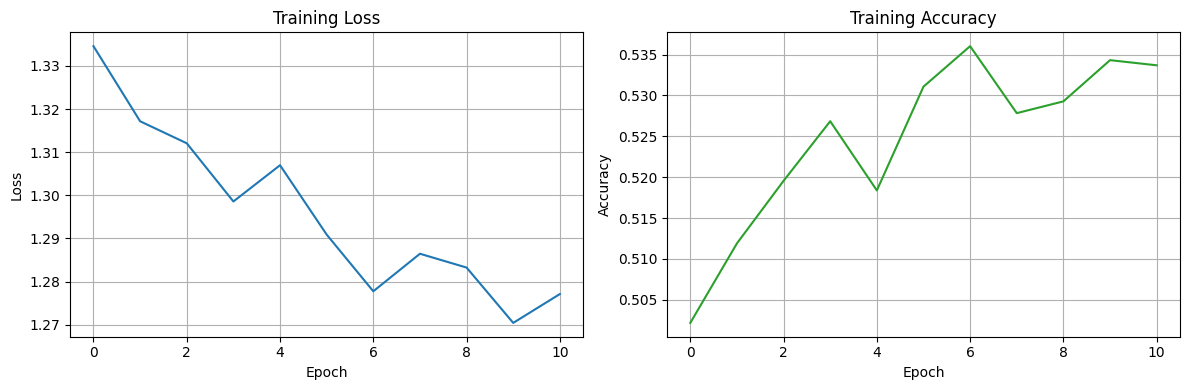

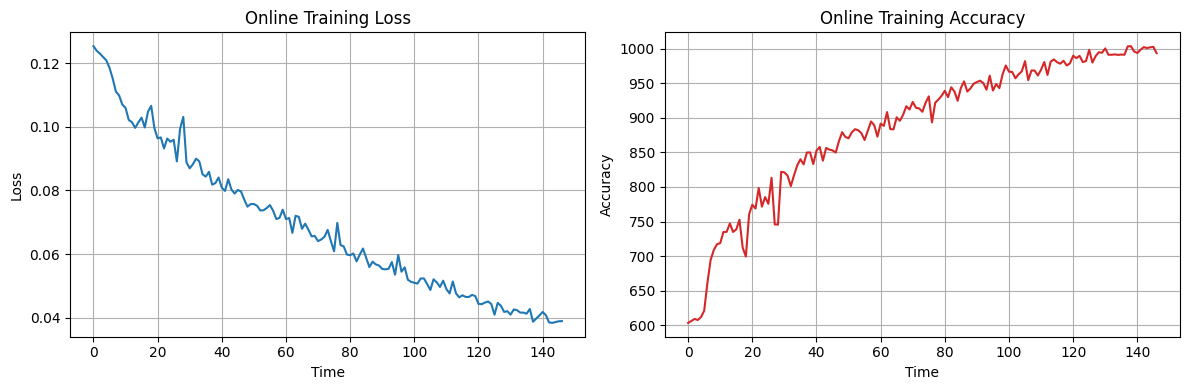

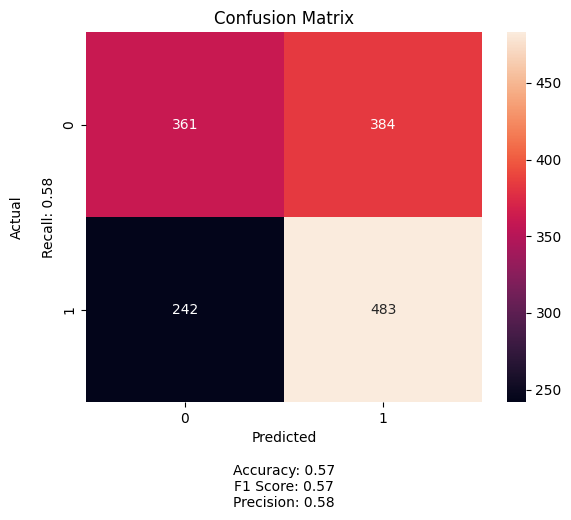

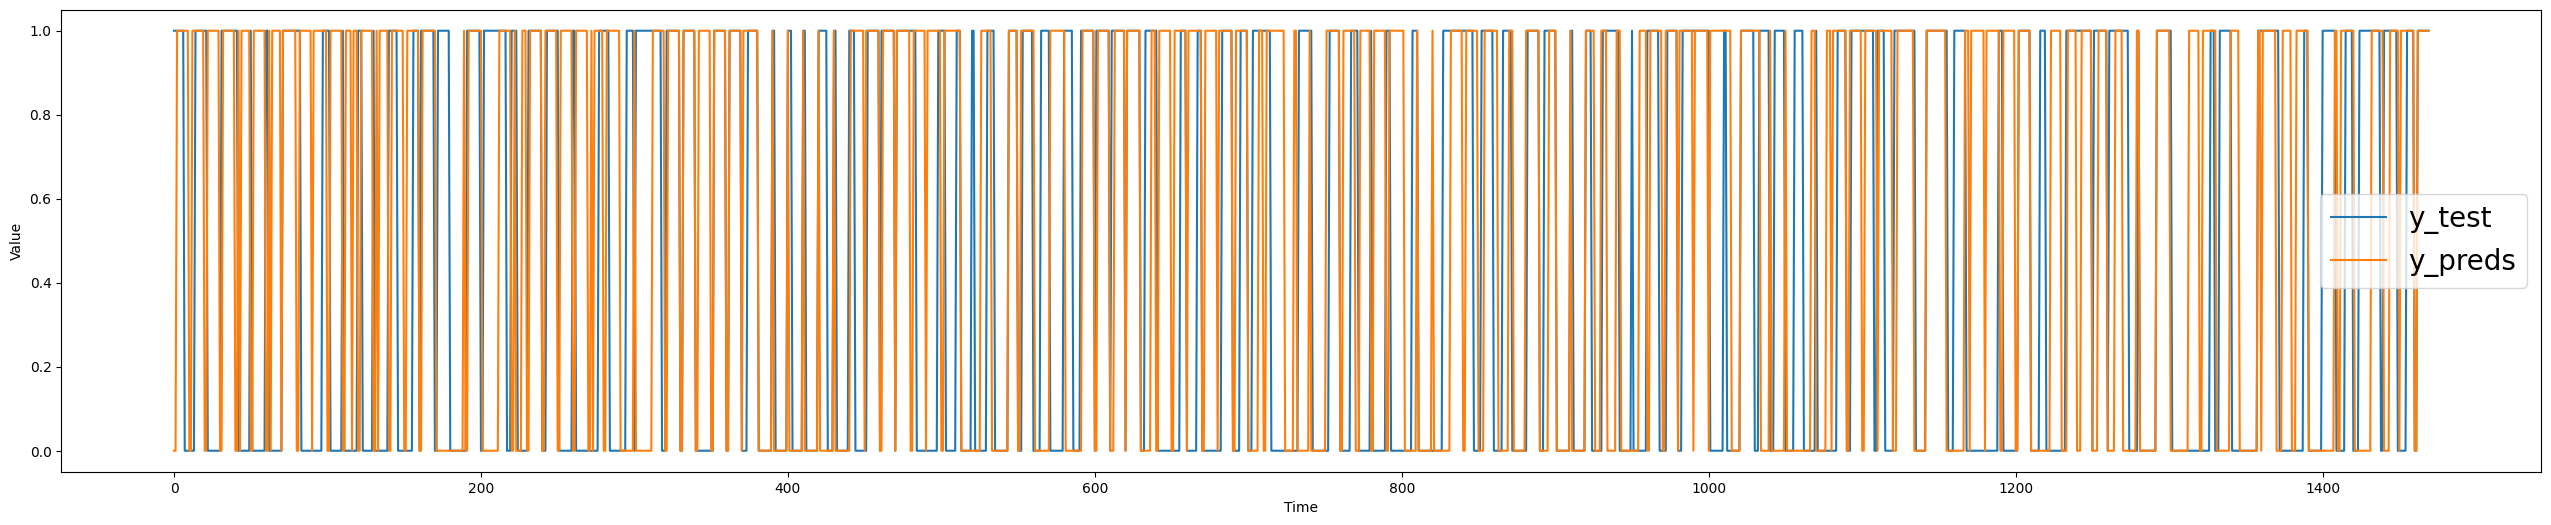

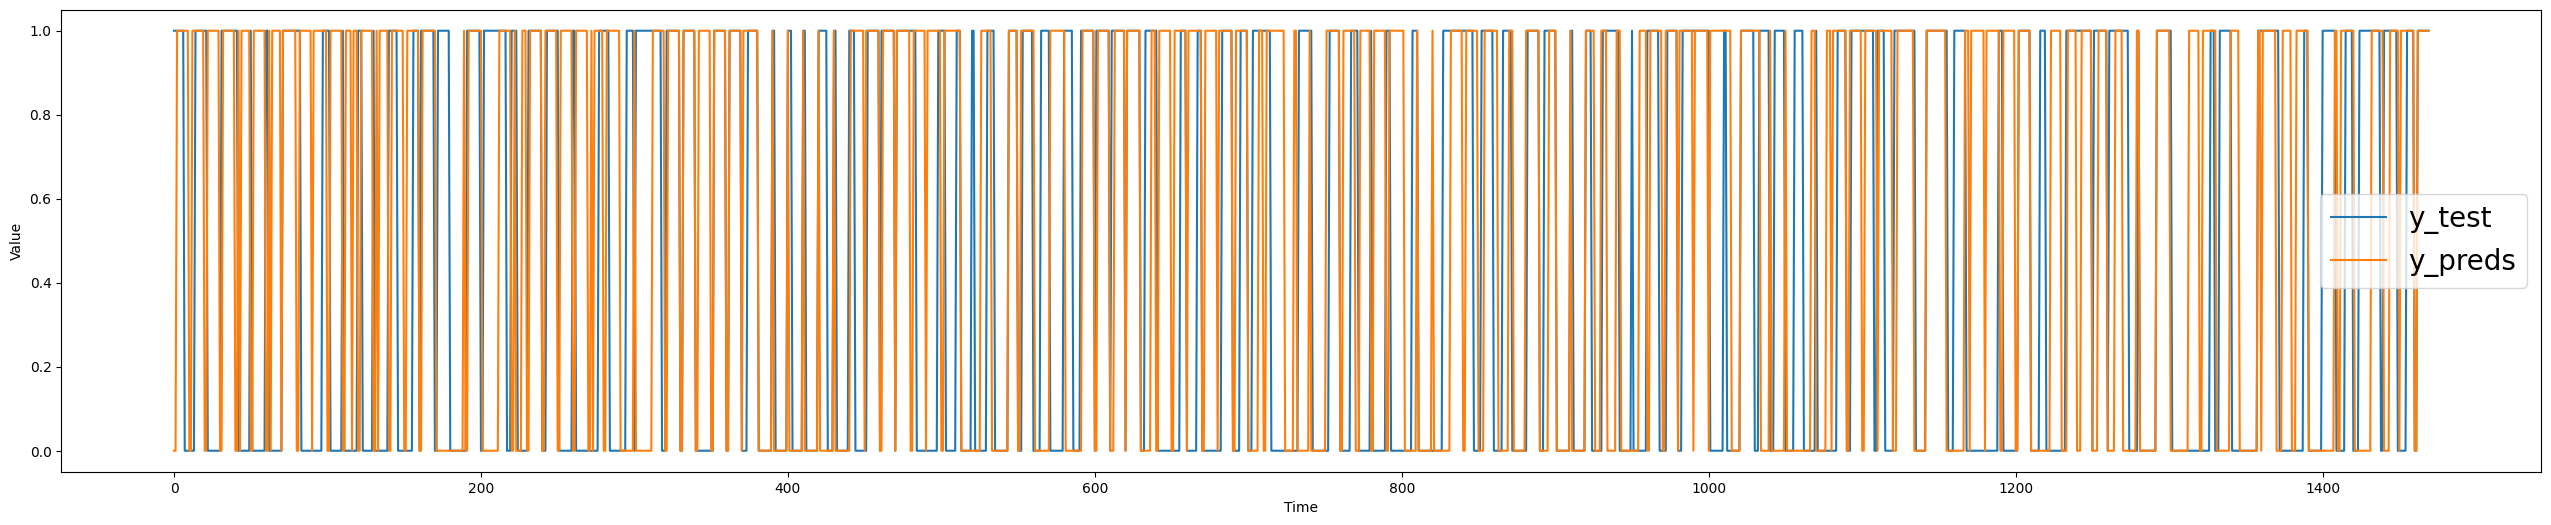

C:\Users\e4903\AppData\Local\Temp\ipykernel_17912\2628515794.py:192: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buy_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Buy') | (trade_signals['Signal'] == 'Buy (first)')]
C:\Users\e4903\AppData\Local\Temp\ipykernel_17912\2628515794.py:197: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sell_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Sell') | (trade_signals['Signal'] == 'Sell (first)')]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


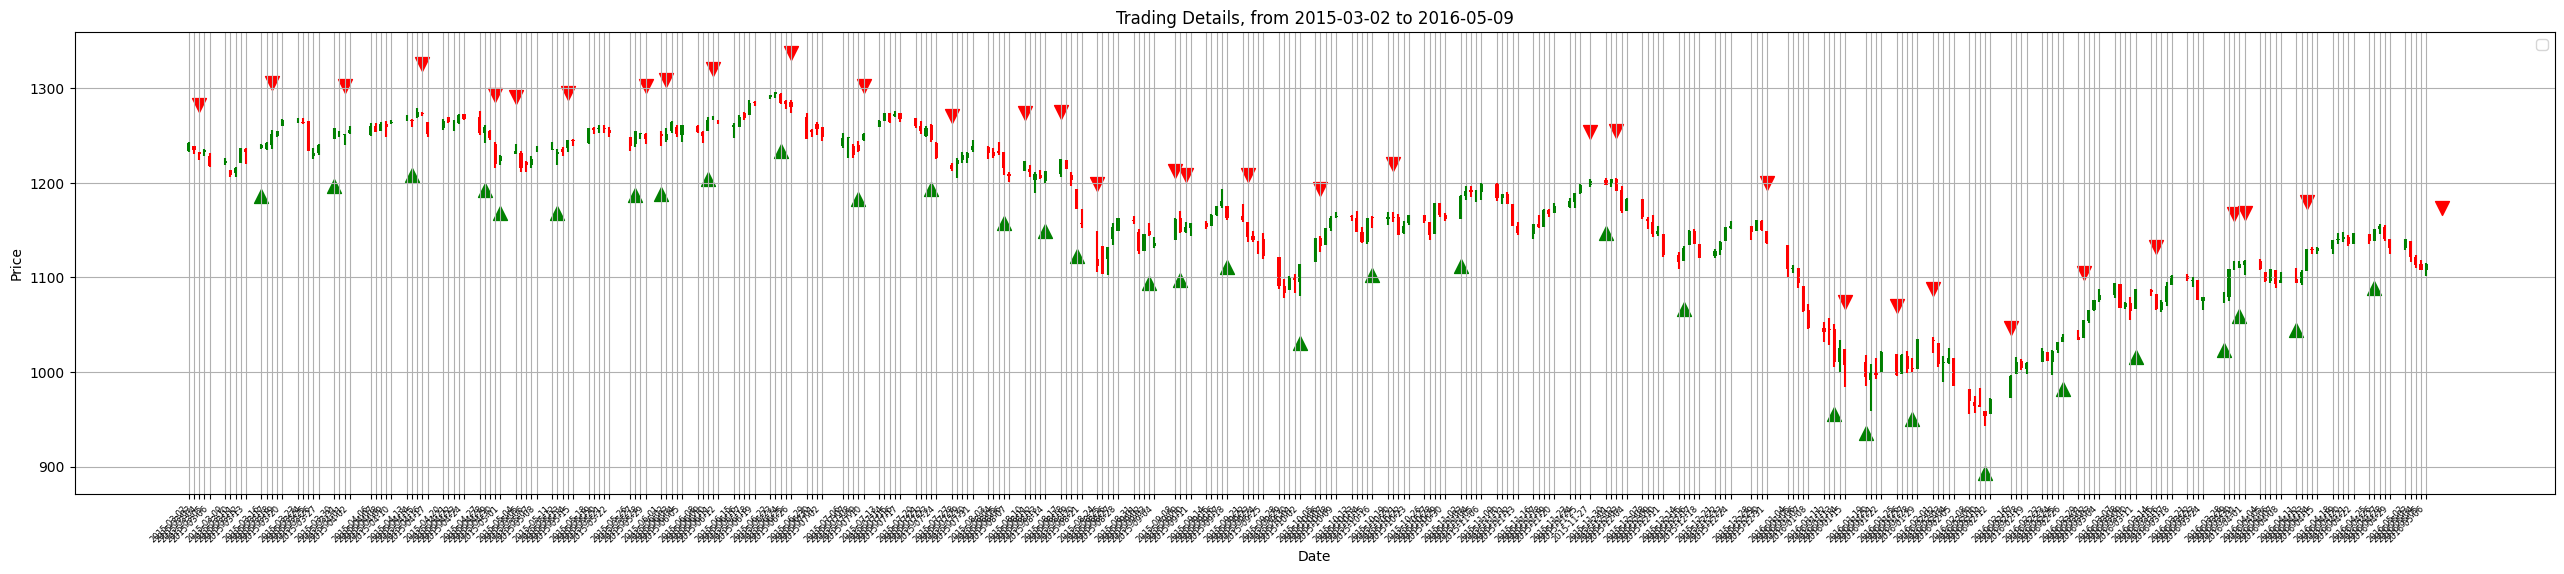

C:\Users\e4903\AppData\Local\Temp\ipykernel_17912\2628515794.py:192: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buy_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Buy') | (trade_signals['Signal'] == 'Buy (first)')]
C:\Users\e4903\AppData\Local\Temp\ipykernel_17912\2628515794.py:197: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sell_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Sell') | (trade_signals['Signal'] == 'Sell (first)')]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


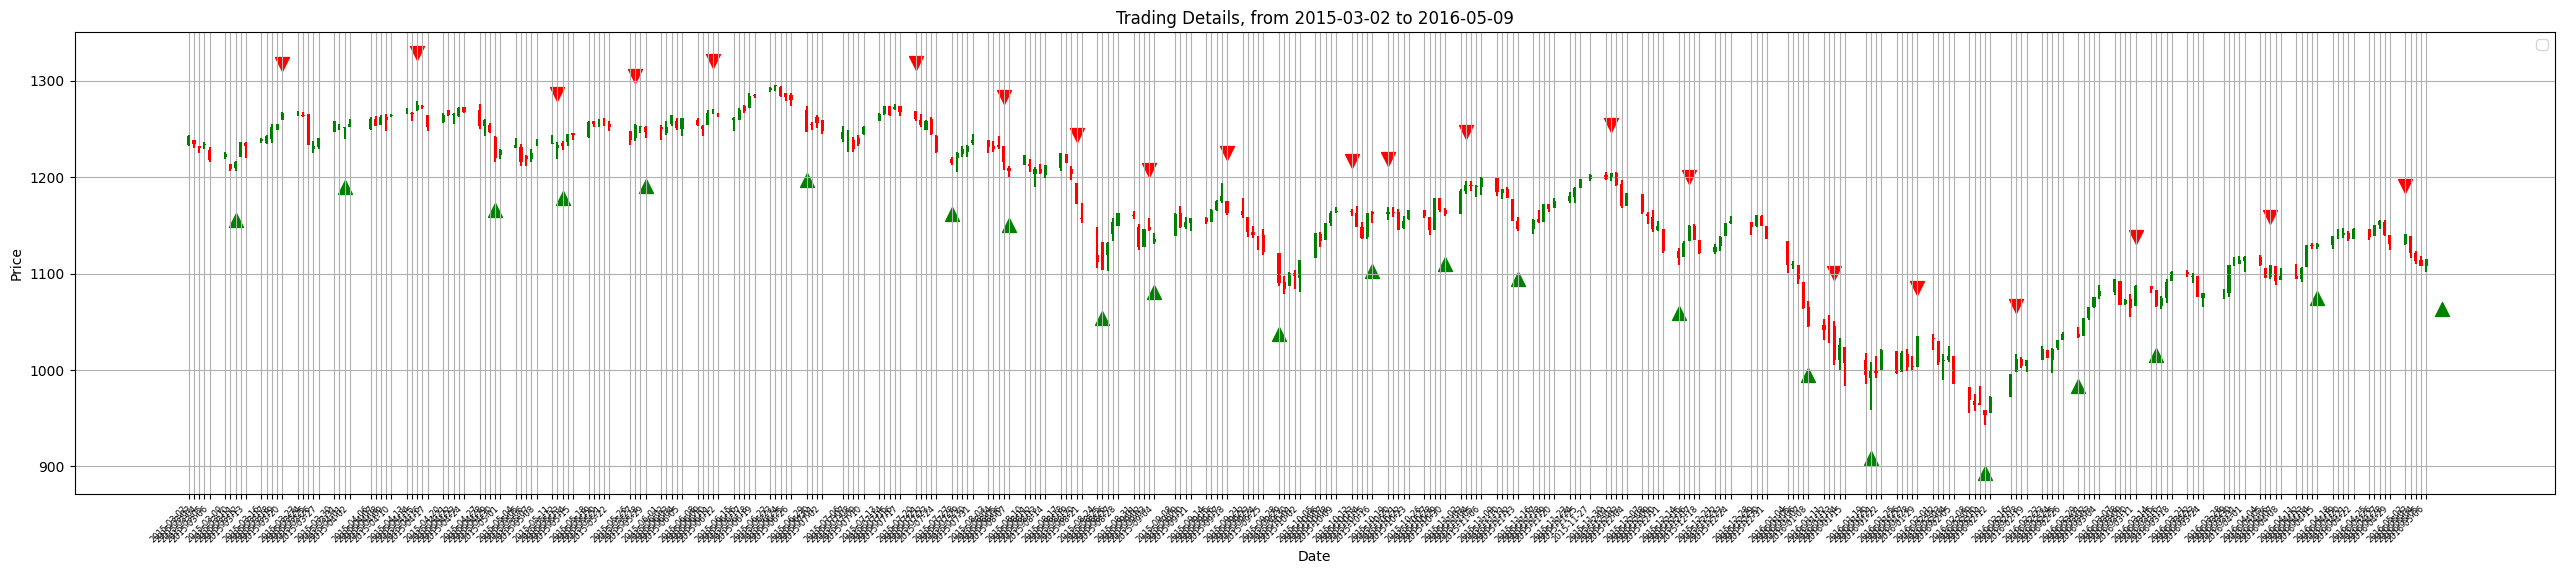

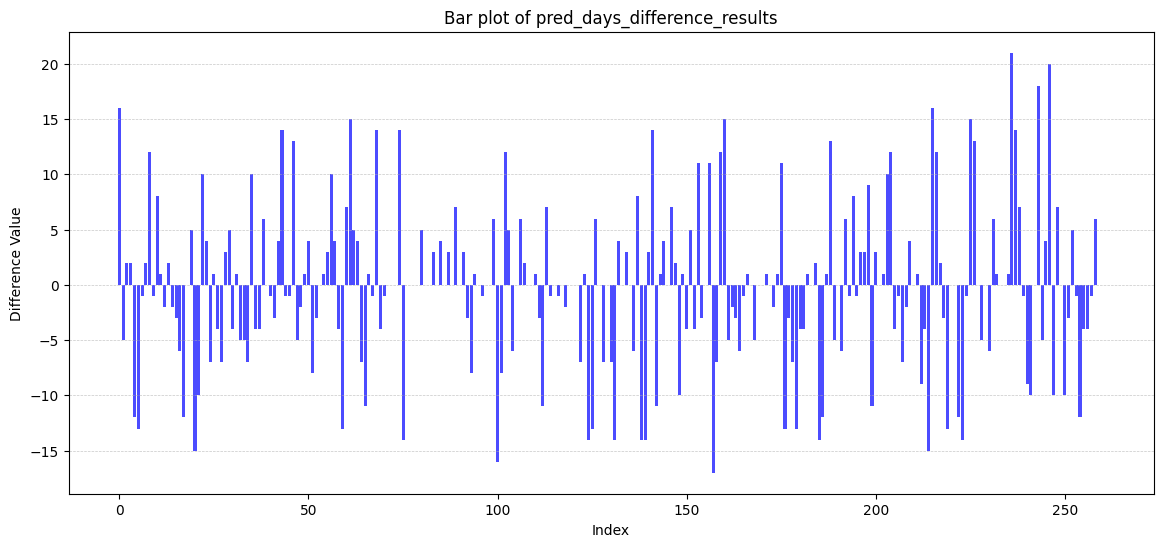

'ModelDNN(\n  (fc1): Linear(in_features=608, out_features=320, bias=True)\n  (fc2): Linear(in_features=320, out_features=160, bias=True)\n  (fc3): Linear(in_features=160, out_features=80, bias=True)\n  (fc4): Linear(in_features=80, out_features=40, bias=True)\n  (fc5): Linear(in_features=40, out_features=20, bias=True)\n  (ln1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)\n  (ln2): LayerNorm((160,), eps=1e-05, elementwise_affine=True)\n  (ln3): LayerNorm((80,), eps=1e-05, elementwise_affine=True)\n  (ln4): LayerNorm((40,), eps=1e-05, elementwise_affine=True)\n  (ln5): LayerNorm((20,), eps=1e-05, elementwise_affine=True)\n  (dropout): Dropout(p=0.5, inplace=False)\n), \nNumber of parameter: 264420'

'\nAccuracy: 0.57\nPrecision: 0.58\nRecall: 0.58\nF1 Score: 0.57\n\n        '

,sharpe_ratio,initial_value,final_value,total_return
0,-1.268368,10000.0,9709.044545,0.970904


In [40]:
evaluator = Evaluator()
total = sum([param.nelement() for param in model.parameters()])
model_summary = f'{model}, \nNumber of parameter: {total}'
print(model_summary)
evaluator.generate_report(model, y_test, y_preds, history, 
                        online_training_acc, online_training_losses,
                        data, pred_trade_signals, test_trade_signals, x_start=0, x_stop=300)


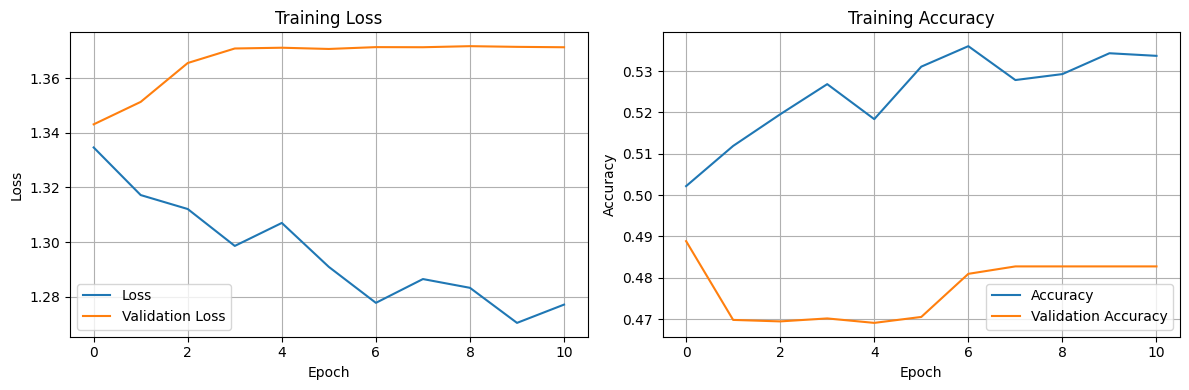

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss and validation loss
ax1.plot(history['loss'], label='Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(history['binary_accuracy'], label='Accuracy')
ax2.plot(history['val_binary_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()
